In [38]:
from astropy.table import Table, QTable, Column
import numpy as np
import astropy.units as u
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from scipy.stats import norm
import matplotlib.mlab as mlab
from astropy.nddata.utils import Cutout2D
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats
import scipy
from scipy import ndimage
from numpy.linalg import eig, inv
import matplotlib.patches as patches

##-------------------------Importing Everything I Will Need-----------------------------------##

hdu = pyfits.open('C:/Users/dougl/Desktop/smcw2-nd-intbgsub.fits', ignore_missing_end=True)
w = WCS(hdu[0].header)


In [3]:
from astropy.io import ascii
catalog = Table.read('C:/Users/dougl/Desktop/asu(1).fit', format = 'fits')
print(catalog)

 RAJ2000    IDra    DEJ2000   Umag  e_Umag ... e_Imag Flag Jmag Hmag Ksmag
   deg       h        deg     mag    mag   ...  mag        mag  mag   mag 
--------- -------- --------- ------ ------ ... ------ ---- ---- ---- -----
 5.617095 0.374473 -74.89902  20.53  0.165 ...  0.048   10  nan  nan   nan
 5.617995 0.374533 -74.88598    nan    nan ...    nan    0  nan  nan   nan
 5.618685 0.374579 -74.89183 21.784  0.497 ...  0.149    0  nan  nan   nan
 5.618955 0.374597 -74.89297    nan    nan ...   0.26    0  nan  nan   nan
  5.61939 0.374626 -74.86275    nan    nan ...    nan    0  nan  nan   nan
  5.61969 0.374646 -74.89796    nan    nan ...    nan    0  nan  nan   nan
  5.62077 0.374718 -74.88685    nan    nan ...  0.283    0  nan  nan   nan
 5.622585 0.374839 -74.89294    nan    nan ...  0.321    0  nan  nan   nan
 5.622675 0.374845 -74.89507 20.146  0.164 ...  0.216    0  nan  nan   nan
 5.623395 0.374893 -74.89001 21.913  0.506 ...  0.331    0  nan  nan   nan
      ...      ...       

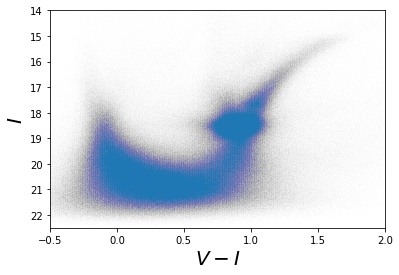

In [4]:
Vmag = catalog["Vmag"]
Imag = catalog["Imag"]
VImag = Vmag - Imag
plt.scatter(VImag, Imag, s=0.001, alpha=0.025)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.xlim(-0.5,2)
plt.ylim(22.5,14)
plt.show()

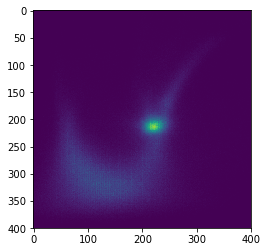

In [5]:
Vmag = catalog["Vmag"]
Imag = catalog["Imag"]
VImag = Vmag - Imag
NaNs1 = np.isnan(VImag)
NaNs2 = np.isnan(Imag)
VImag[NaNs1]= -9999
Imag[NaNs2] = -9999
bins = (400,400)
H1, xedges1, yedges1 = np.histogram2d(Imag, VImag, bins, range=[[14,22.5], [-0.5, 2]])
plt.imshow(H1)

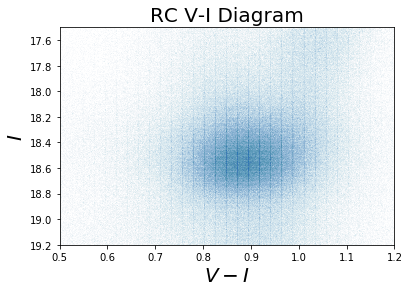

In [6]:
plt.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.001, alpha=0.15)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.xlim(0.5,1.2)
plt.ylim(19.2,17.5)
plt.title("RC V-I Diagram", fontsize=20)

##------------------Trying to locate the Red Clump Stars----------------------------##

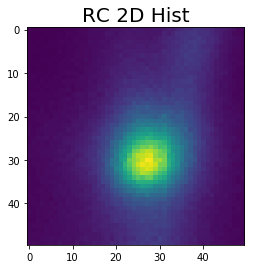

In [7]:
Vmag = catalog["Vmag"]
Imag = catalog["Imag"]
VImag = Vmag - Imag
NaNs1 = np.isnan(VImag)
NaNs2 = np.isnan(Imag)
VImag[NaNs1]= -9999
Imag[NaNs2] = -9999
bins = (50,50)
H, xedges, yedges = np.histogram2d(Imag, VImag, bins, range=[[17.5, 19.2], [0.5, 1.2]])
plt.imshow(H)
plt.title("RC 2D Hist", fontsize=20)

(50, 50)


<a list of 6 text.Text objects>

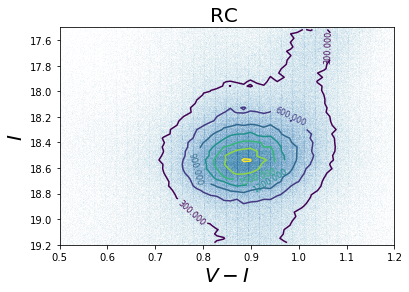

In [8]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.001, alpha=0.15)
H, xedges, yedges = np.histogram2d(VImag, Imag, bins, range=[[0.5, 1.2], [17.5, 19.2]])
print(H.shape)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
cset1 = ax.contour(H.T,extent=extent,aspect=1,origin='lower')
plt.xlim(0.5,1.2)
plt.ylim(17.5,19.2)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.title("RC ", fontsize=20)
ax.clabel(cset1, fontsize=8)

<class 'list'>
<class 'list'>


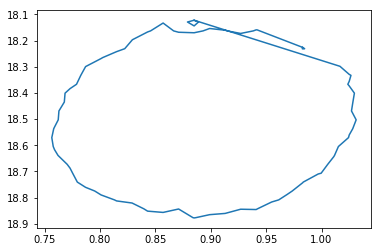

In [9]:
points = cset1.collections[1].get_paths()
print(type(points))

points2 =[[  0.88500003,  18.122275  ],
       [  0.88893753,  18.12900028],
       [  0.88500003,  18.14392712],
       [  0.87900003,  18.12900028],
       [  0.88500003,  18.122275  ],
       [  1.01670374,  18.298439  ],
       [  1.01680314,  18.29900036],
       [  1.02500004,  18.32925234],
       [  1.02655559,  18.33300037],
       [  1.02500004,  18.35566705],
       [  1.02374363,  18.36700039],
       [  1.02500004,  18.37343282],
       [  1.0296667 ,  18.4010004 ],
       [  1.02832055,  18.43500042],
       [  1.0270364 ,  18.46900043],
       [  1.03125536,  18.50300045],
       [  1.02816133,  18.53700047],
       [  1.02500004,  18.56080048],
       [  1.02433337,  18.57100048],
       [  1.01523533,  18.6050005 ],
       [  1.01172596,  18.63900051],
       [  1.01100003,  18.64406434],
       [  1.00561542,  18.67300053],
       [  0.9996667 ,  18.70700054],
       [  0.99700003,  18.71002277],
       [  0.98349415,  18.74100056],
       [  0.98300003,  18.74342913],
       [  0.97358624,  18.77500057],
       [  0.96900003,  18.78818425],
       [  0.96136367,  18.80900059],
       [  0.95500003,  18.81709583],
       [  0.94227276,  18.8430006 ],
       [  0.94100003,  18.84589422],
       [  0.92700003,  18.84471778],
       [  0.91300003,  18.86078043],
       [  0.89900003,  18.86551413],
       [  0.88650003,  18.87700062],
       [  0.88500003,  18.87794506],
       [  0.88397564,  18.87700062],
       [  0.87100003,  18.8438724 ],
       [  0.85700002,  18.85694061],
       [  0.84300002,  18.85203858],
       [  0.8395412 ,  18.8430006 ],
       [  0.82900002,  18.82102079],
       [  0.81500002,  18.81296726],
       [  0.81307845,  18.80900059],
       [  0.80100002,  18.79006387],
       [  0.79523531,  18.77500057],
       [  0.78700002,  18.76095098],
       [  0.77958211,  18.74100056],
       [  0.77534901,  18.70700054],
       [  0.77300002,  18.68768235],
       [  0.77039218,  18.67300053],
       [  0.76214287,  18.63900051],
       [  0.75900002,  18.6170005 ],
       [  0.75783335,  18.6050005 ],
       [  0.75652943,  18.57100048],
       [  0.75826318,  18.53700047],
       [  0.75900002,  18.53062546],
       [  0.76233947,  18.50300045],
       [  0.76297635,  18.46900043],
       [  0.7678369 ,  18.43500042],
       [  0.76850528,  18.4010004 ],
       [  0.77300002,  18.38371706],
       [  0.77885818,  18.36700039],
       [  0.78269233,  18.33300037],
       [  0.78700002,  18.29982963],
       [  0.7872414 ,  18.29900036],
       [  0.80100002,  18.26871909],
       [  0.80250771,  18.26500034],
       [  0.81500002,  18.24233367],
       [  0.82238184,  18.23100033],
       [  0.82900002,  18.19825957],
       [  0.82920898,  18.19700031],
       [  0.84300002,  18.1670803 ],
       [  0.84568087,  18.1630003 ],
       [  0.85700002,  18.13295377],
       [  0.86650002,  18.1630003 ],
       [  0.87100003,  18.16818674],
       [  0.88500003,  18.17010939],
       [  0.89305003,  18.1630003 ],
       [  0.89900003,  18.15382569],
       [  0.91300003,  18.16042454],
       [  0.91494447,  18.1630003 ],
       [  0.92700003,  18.17275956],
       [  0.93842108,  18.1630003 ],
       [  0.94100003,  18.1589664 ],
       [  0.94195288,  18.15920925],
       [  0.98300003,  18.22614318],
       [  0.98262165,  18.23100033],
       [  0.98300003,  18.23173946],
       [  0.98475003,  18.23100033],
       [  0.98300003,  18.22614318]]

print(type(points2))

testList2 = []
x1 = []
y1 = []
for (elem1, elem2) in points2:
    testList2 += [(elem1, elem2)]
    x1 += [elem1]
    y1 += [elem2]

zip(*testList2)
plt.plot(*zip(*testList2))
plt.ylim(reversed(plt.ylim()))
plt.show()

x1 = np.array(x1)
x2 = x1.flatten()

y1 = np.array(y1)
y2 = y1.flatten()

[ 0.13456411  0.36261906]


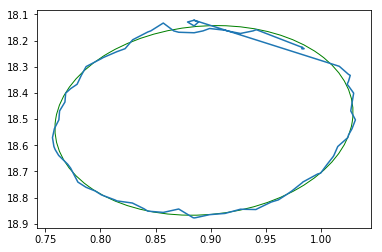

In [10]:

def fitEllipse( x , y ):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2
        
def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

a = fitEllipse(x=x2,y=y2)
center = ellipse_center(a)
phi = ellipse_angle_of_rotation(a)
axes = ellipse_axis_length(a)

print(axes)

b1, a1 = axes
angle1 = np.degrees(phi)
fig, ax = plt.subplots(nrows=1,ncols=1)
g_ell_center = (0.89392022,18.5051778)
g_ellipse = patches.Ellipse(g_ell_center, 0.72523812, 0.26912822, angle=angle1, fill=False, edgecolor='green')
ax.add_patch(g_ellipse)

from pylab import *
plt.plot(*zip(*testList2))
plt.ylim(reversed(plt.ylim()))
show()

(19.199999999999999, 17.5)

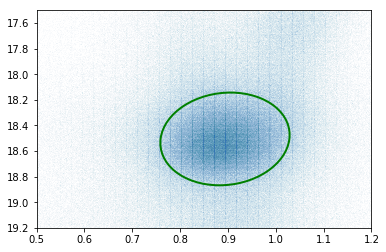

In [11]:
plt.figure(figsize=(8,8))
fig, ax = plt.subplots(nrows=1,ncols=1)
g_ell_center = (0.89392022,18.5051778)
g_ellipse = patches.Ellipse(g_ell_center, 0.72523812, 0.26912822, angle=angle1, fill=False, edgecolor='green', linewidth=2)
ax.add_patch(g_ellipse)
ax.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.001, alpha=0.15)

plt.xlim(0.5,1.2)
plt.ylim(17.5,19.2)
plt.ylim(reversed(plt.ylim()))

In [12]:
cos_angle = np.cos(np.radians(180.-angle1))
sin_angle = np.sin(np.radians(180.-angle1))
RC_ra=[]
RC_dec=[]
RC_Vmag=[]
RC_VImag=[]
RC_Imag=[]

for i in range(0,5156056):
    Vmag = catalog["Vmag"][i]
    Imag = catalog["Imag"][i]
    VImag = Vmag - Imag
    ra = catalog["RAJ2000"][i]
    dec = catalog["DEJ2000"][i]

    xc = VImag - g_ell_center[0]
    yc = Imag - g_ell_center[1]

    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 

    rad_cc = (xct**2/(0.72523812/2.)**2) + (yct**2/(0.26912822/2.)**2)

    if rad_cc <= 1.:
        # point in ellipse
        RC_ra.append(ra)
        RC_dec.append(dec)
        RC_Vmag.append(Vmag)
        RC_VImag.append(VImag)
        RC_Imag.append(Imag)

In [13]:
RC_loc = Table()
RC_loc['RAJ2000'] = RC_ra
RC_loc['DEJ2000'] = RC_dec
print(RC_loc)

 RAJ2000   DEJ2000 
--------- ---------
 5.629545 -74.83324
 5.637225 -74.86771
 5.637405 -74.84274
 5.639715 -74.87654
 5.661735 -74.69741
  5.66385 -74.83868
  5.66781 -74.81807
  5.66976 -74.90128
  5.67471 -74.89833
 5.685795 -74.74405
      ...       ...
 20.56878 -74.62782
 20.57388 -74.69594
20.574525 -74.82275
 20.57655  -74.8679
 20.57928 -74.87347
  20.5866 -74.78902
 20.59179 -74.82719
 20.59272 -74.71071
20.596725 -74.78487
20.604765 -74.69199
 20.61288 -74.87856
Length = 351217 rows


(19.199999999999999, 17.5)

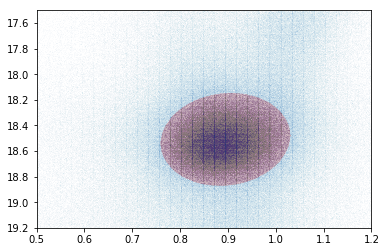

In [14]:
fig,ax = plt.subplots(1)
ax.scatter(RC_VImag,RC_Imag, s=0.001, c='r', alpha=0.15)
ax.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.001, alpha=0.15)
plt.xlim(0.5,1.2)
plt.ylim(17.5,19.2)
plt.ylim(reversed(plt.ylim()))

In [15]:
r=10 * u.arcsec
RC_positions = SkyCoord(ra=RC_loc['RAJ2000'] * u.deg, dec=RC_loc['DEJ2000'] * u.deg, frame='fk5')
RC_apertures = SkyCircularAperture(RC_positions, r)
RC_phot_table = aperture_photometry(hdu[0], RC_apertures)
RC_Flux = RC_phot_table['aperture_sum']
NUV_magnitude = -2.5*np.log10(RC_Flux) + 20.08
print(RC_phot_table)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in log10


  id        xcenter       ...    aperture_sum   
              pix         ...                   
------ ------------------ ... ------------------
     1  20540.63274116567 ...    0.0299144130623
     2  20521.19194809172 ...    0.0726295363422
     3 20531.716529022127 ...     0.141092599687
     4  20515.89240887896 ...    0.0577155977983
     5 20578.413819220787 ...    0.0438408103614
     6 20517.066745073895 ...    0.0339459423203
     7  20523.36764356137 ...    0.0306907491726
     8 20486.823229532016 ...   -0.0164508280508
     9  20485.02173133492 ...    0.0366781419874
    10 20543.598333127808 ...   -0.0027252864231
   ...                ... ...                ...
351208 11164.018979139812 ...  -0.00663877388736
351209  11186.05737805507 ...    0.0089572103409
351210  11192.78343208734 ...     0.442995191757
351211  11192.06416988169 ...  -0.00193818042563
351212 11172.501799055899 ...  9.30895008504e-05
351213  11176.02442594219 ...    0.0114671061404
351214 11154.7385647

In [92]:
from astropy.coordinates import match_coordinates_sky
coord = SkyCoord(ra = catalog['RAJ2000'], dec= catalog['DEJ2000'], frame='fk5')
idx, d2d, d3d = match_coordinates_sky(RC_positions, coord, nthneighbor=2)

def Isolate_RC(x, y):
    x0, y0 = skycoord_to_pixel(coord,w)
    x = x.value
    y = y.value
    j = 0
    x_iso = []
    y_iso = []
    idx_iso = []
    for i in idx:
        if j < len(x):
            xc = x0[i] - x[j]
            yc = y0[i] - y[j]
            rad = xc**2 + yc**2
            if rad >= 5**2:
                x_iso.append(x[j])
                y_iso.append(y[j])
                idx_iso.append(i)
            elif catalog['Umag'][i] >= 20:
                x_iso.append(x[j])
                y_iso.append(y[j])
                idx_iso.append(i)
        j = j + 1
    RC_iso = Table()
    RC_iso['xcenter'] = x_iso
    RC_iso['ycenter'] = y_iso
    RC_iso['idx'] = idx_iso
    return RC_iso

RC_iso = Isolate_RC(x = RC_phot_table['xcenter'], y = RC_phot_table['ycenter'])
print(RC_iso)

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in greater_equal


   xcenter       ycenter      idx  
------------- ------------- -------
20521.1919481 4960.01080506      24
 20531.716529 5019.08623061      57
20515.8924089 4939.40394766      36
20578.4138192 5365.53580396     204
20523.3676436 5080.81587516     214
20485.0217313 4891.74325664     292
20605.2400259 5658.19406074     415
20549.7887896 5348.70698575     473
20566.1910543 5449.50482515     484
20481.3181061 4976.26034432     452
          ...           ...     ...
11170.2322668 5961.50124127 5155474
11176.5205943 5846.74375779 5155543
11184.8612466 5678.56047876 5155586
11172.8163781 5833.66634662 5155736
11145.6551237  6193.3877196 5155540
11172.2087606 5795.32706438 5155690
11164.0189791  5857.7131186 5155712
11186.0573781 5554.11446558 5155744
11192.0641699 5432.47861761 5155797
11172.5017991  5634.2985352 5155705
11171.9811686 5418.73577912 5155949
Length = 82872 rows


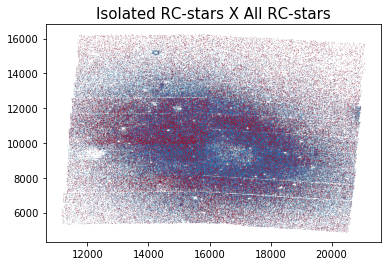

In [93]:
plt.figure(figsize=(10,10))
fig,ax = plt.subplots()
x = RC_phot_table['xcenter']
y = RC_phot_table['ycenter']
x1 = RC_iso['xcenter']
y1 = RC_iso['ycenter']
ax.scatter(x, y, s=0.01, alpha=0.3)
ax.scatter(x1, y1, s=0.01,c='r', alpha = 0.3)
plt.title("Isolated RC-stars X All RC-stars", fontsize = 15)
plt.show()

C:\Users\dougl\Anaconda3\lib\site-packages\astropy\visualization\stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
C:\Users\dougl\Anaconda3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


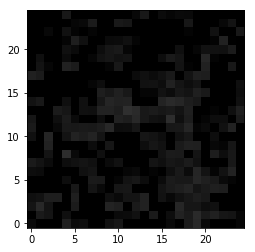

In [94]:
norm = ImageNormalize(stretch=SqrtStretch())
image_data = hdu[0].data
position = (20521.1919481,4960.01080506)
size = (25,25)
cutout = Cutout2D(image_data, position, size)
plt.imshow(cutout.data, norm=norm, origin = 'lower', cmap='Greys_r', vmin=0, vmax=0.15)

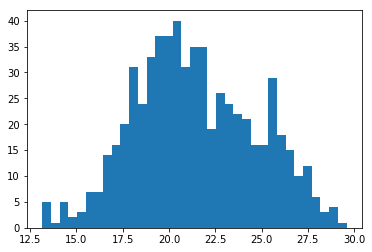

In [95]:
image_concat = []
iso_coord = pixel_to_skycoord(RC_iso['xcenter'],RC_iso['ycenter'],w) 

for i in range(0, 7999):
    position = (iso_coord[i])
    cutout = Cutout2D(image_data, position, size, wcs=w)
    image_concat.append(cutout.data)

final_image = np.sum(image_concat, axis=0)
image_hist = plt.hist(final_image.flatten(), 35)


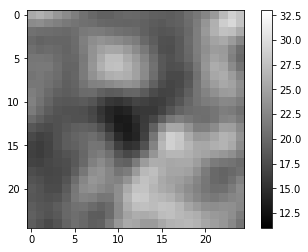

In [99]:
plt.imshow(final_image, cmap='gray', vmin=11, vmax=33)
plt.colorbar()

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in log10


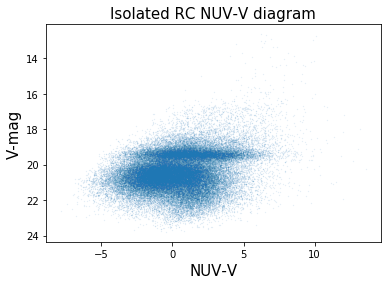

In [102]:
Iso_Vmag = []
for i in RC_iso['idx']:
    Iso_Vmag.append(catalog["Vmag"][i])
r=10 * u.arcsec
RC_IsoPositions = iso_coord
RC_IsoApertures = SkyCircularAperture(RC_IsoPositions, r)
RC_IsoPhot_table = aperture_photometry(hdu[0], RC_IsoApertures)
RC_IsoFlux = RC_IsoPhot_table['aperture_sum']
NUV_magnitude = -2.5*np.log10(RC_IsoFlux) + 20.08
plt.scatter(NUV_magnitude - Iso_Vmag, Iso_Vmag, s=0.05,alpha=0.2)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("NUV-V", fontsize=15)
plt.ylabel("V-mag", fontsize=15)
plt.title("Isolated RC NUV-V diagram", fontsize=15)


C:\Users\dougl\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\dougl\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


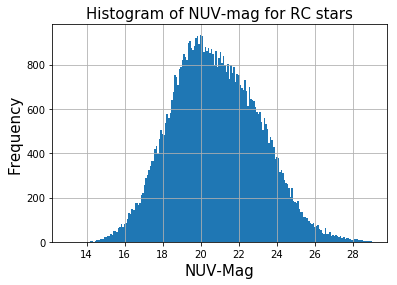

In [103]:
NUV_Mag2 = np.asarray(NUV_magnitude)
NUV_Mag = NUV_Mag2.flatten()
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.hist(NUV_Mag,bins=200,range=(13,29))
plt.xlabel("NUV-Mag", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title(r'Histogram of NUV-mag for RC stars', fontsize=15)
plt.grid(True)
plt.show()